# Технологии регуляризации в пространствах L1 и L2. Метод Dropout.

Рассмотрим применения сверточной  нейронной сети  и методы регуляризации А.Н. Тихонова для переобученных моделей.Для этой цели в пространствах и  L1 L2 будем решать задачу минимизации функционала ошибок и их регуляризации.

##  Методы  регуляризации в технологиях сверточных нейронных сетей (CNN )

 Мы рассмотрим  CNN и методах их регуляризации,которые доступны  API TensorFlow  и Keras. Сначала я попытаюсь дать вам интуитивное представление о том, что такое сверточная нейронная сеть, а затем познакомлю вас с методами регуляризации.

Регуляризация
Представьте, что у вас есть модель, которая научилась распознавать изображения кошек. Модель, которую вы определили, имеет множество параметров. Вы заметите, что значение потерь минимально, однако, когда вы развернете свою модель для обнаружения изображения кошки в других условиях по сравнению с вашим обучающим набором, вы заметите, что ваша модель не сможет очень хорошо распознавать кошку.

Это происходит потому, что ваша модель очень хорошо показала себя на тренировочном наборе. Мы используем термин «переобучение» для описания моделей, которые очень хорошо работают на обучающем наборе, но не могут хорошо обобщать на тестовом наборе (наборе изображений, которые ваша модель раньше не видела).

В отличие от людей, машина не видит изображение таким, какое оно есть. Когда машинам предоставляется изображение, они видят числа или матрицу пикселей, как показано ниже.

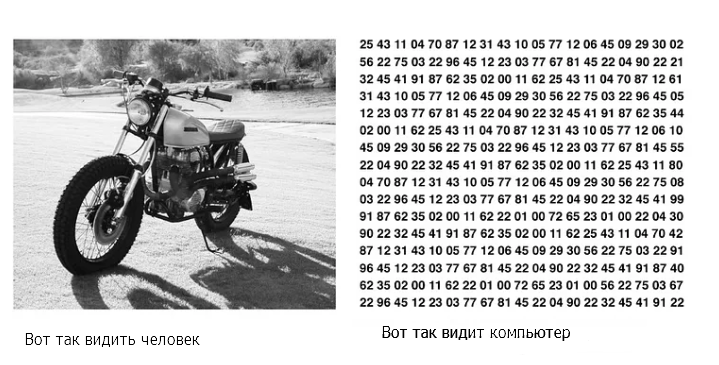

Давайте сначала импортируем все библиотеки и пакеты, которые мы собираемся использовать.

In [ ]:
import os
import tensorflow as tf
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator
from multiprocessing import Pool
import matplotlib.pyplot as plt

Вам нужна функция для построения графика потерь и точности обученной модели, чтобы вы могли наблюдать изменения графически.

In [2]:
def show_final_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    ax[0].set_title('loss')
    ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
    ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
    ax[1].set_title('acc')
    ax[1].plot(history.epoch, history.history["accuracy"], label="Train acc")
    ax[1].plot(history.epoch, history.history["val_accuracy"], label="Validation acc")
    ax[0].legend()
    ax[1].legend()

Для предварительной обработки Keras есть класс ImageDataGenerator. Он генерирует пакеты данных тензорного изображения с увеличением данных в реальном времени. При этом вы можете добавить любую форму увеличения данных и указать разделение проверки. Здесь я использовал переворот по горизонтали, переворот по вертикали, сдвиг по высоте и изменение масштаба для увеличения. Причина, по которой вы можете использовать перевороты, заключается в том, что вы можете сфотографировать свою руку под любым углом. Таким образом, используя переворот, вы поможете своей модели лучше обобщать различные сценарии. Если бы он сказал: тренируйтесь на горизонтальных изображениях рук, он бы не смог предсказать руки в вертикальной ориентации.

# Модель с использованием CNN


In [3]:
data_dir = 'C:/Users/User/Desktop/Database_regulyarizazia/Database_rps-cv-images/'
augs_gen = ImageDataGenerator(
    rescale=1./255,        
    horizontal_flip=True,
    height_shift_range=.2,
    vertical_flip = True,
    validation_split = 0.2
)  

train_gen = augs_gen.flow_from_directory(
    data_dir,
    target_size = (224,224),
    batch_size=32,
    class_mode = 'categorical',
    shuffle=True,
)

val_gen = augs_gen.flow_from_directory(
    data_dir,
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False,
    subset = 'validation'
)

Found 2188 images belonging to 3 classes.
Found 437 images belonging to 3 classes.


Теперь, когда мы закончили предварительную обработку, давайте определим наши модели. Мы собираемся создать 4 модели: одну без регуляризации и 3 модели с упомянутой выше техникой регуляризации. Затем мы собираемся наблюдать за потерями и точностью нашей модели.

Модельная архитектура
Сначала мы собираемся использовать модель без регуляризации. Модель имеет 4 слоя конв-пула и 2 плотных слоя.

In [4]:
model = tf.keras.models.Sequential([
    # layer 1
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(224, 224, 3), use_bias=True),
    tf.keras.layers.MaxPooling2D(2,2),
    # layer 2
    tf.keras.layers.Conv2D(64, (3,3), activation = 'relu', use_bias=True),
    tf.keras.layers.MaxPooling2D(2,2),
    # layer 3
    tf.keras.layers.Conv2D(128, (3,3), activation = 'relu', use_bias=True),
    tf.keras.layers.MaxPooling2D(2,2),
    # layer 4
    tf.keras.layers.Conv2D(128, (3,3), activation = 'relu', use_bias=True),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    # layer 5
    tf.keras.layers.Dense(512, activation = 'relu', use_bias=True),
    # layer 6
    tf.keras.layers.Dense(3, activation='softmax', use_bias=True)
    
])

В коде вы можете увидеть Conv2D, MaxPooling2D, Flatten и Dense. Позвольте мне объяснить, что делают эти функции.

Conv2D: Conv2D выполняет двумерную свертку ваших изображений. Он принимает на входе тензор (матрицу с более чем двумя измерениями) и выдает на выходе свернутый тензор. Он принимает следующие параметры: количество фильтров, размерность фильтра, регуляризацию, а если это первый слой, то форму входа, функцию активации.
MaxPooling2D: выполняет объединение 2D-данных. В качестве параметров ему нужна только форма фильтра пула. Уменьшает форму Матрицы
Плотный: он просто описывает слой нейронов. Вам необходимо предоставить функцию активации
Свести: выравнивает данные. Выходной слой конвектора имеет формат 2D или более. Таким образом, Flatten преобразует их в одномерный вектор.
Вот краткое описание модели

Из сводной информации о модели вы хотите определить, какие слои имеют наибольшее количество параметров. Я собираюсь применить регуляризацию к трем слоям с самыми высокими параметрами. Из приведенного выше фрагмента мы видим, что плотность, conv2d_3 и conv2d_2 имеют самые большие параметры. Итак, я собираюсь применить регуляризацию к этим слоям.

Мы используем model.compile(), чтобы указать, какой тип потерь, оптимизатор мы будем использовать и какую метрику мы хотим наблюдать. После того, как вы скомпилировали свою модель, начните ее обучение с помощью model.fit().

In [5]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 128)      0

Переменная истории хранит информацию о вашей обученной модели. Как только вы начнете обучение с помощью model.fit(), вы заметите, что API TensorFlow Keras будет обучаться и проверять некоторые шаги, выдавая ваши потери и точность обучения, а также потери и точность проверки.

In [6]:
model.compile(loss = 'categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [7]:
history = model.fit(train_gen, epochs=20, validation_data = val_gen, verbose = 1)


Epoch 1/20
69/69 [==============================] - 51s 731ms/step - loss: 1.0974 - accuracy: 0.3935 - val_loss: 1.0205 - val_accuracy: 0.4416
Epoch 2/20
69/69 [==============================] - 50s 724ms/step - loss: 0.6755 - accuracy: 0.7171 - val_loss: 0.5084 - val_accuracy: 0.8673
Epoch 3/20
69/69 [==============================] - 50s 729ms/step - loss: 0.3129 - accuracy: 0.8921 - val_loss: 0.1734 - val_accuracy: 0.9474
Epoch 4/20
69/69 [==============================] - 50s 727ms/step - loss: 0.1934 - accuracy: 0.9342 - val_loss: 0.0926 - val_accuracy: 0.9703
Epoch 5/20
69/69 [==============================] - 50s 726ms/step - loss: 0.1597 - accuracy: 0.9452 - val_loss: 0.3721 - val_accuracy: 0.8558
Epoch 6/20
69/69 [==============================] - 50s 725ms/step - loss: 0.1326 - accuracy: 0.9538 - val_loss: 0.1518 - val_accuracy: 0.9497
Epoch 7/20
69/69 [==============================] - 51s 731ms/step - loss: 0.1121 - accuracy: 0.9671 - val_loss: 0.1395 - val_accuracy: 0.9519

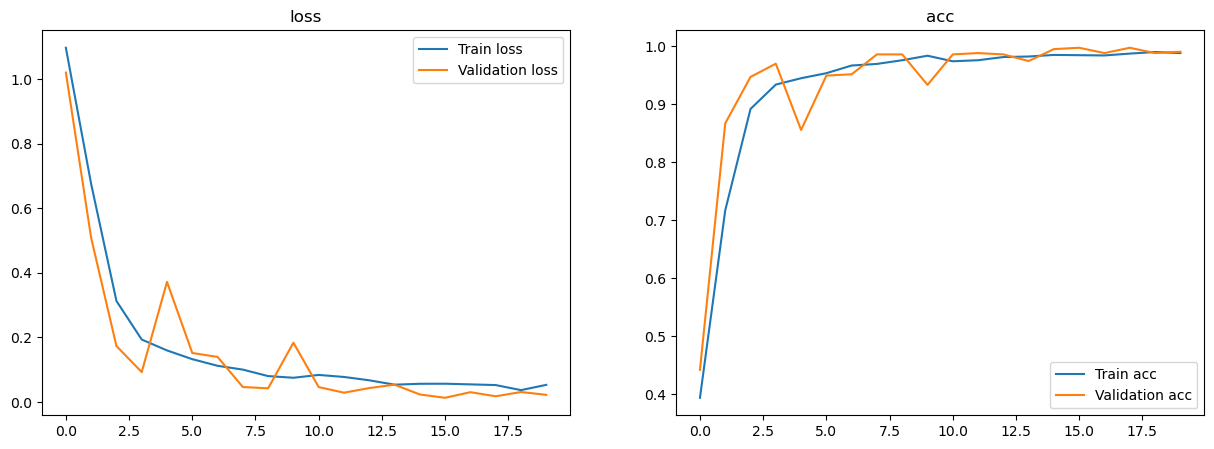

In [8]:
show_final_history(history)

Затем вызовите функцию show_history, чтобы просмотреть график потерь и график точности как для обучения, так и для проверки каждого из них. Для модели без регуляризации график выглядит примерно так.

In [9]:
def show_final_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    ax[0].set_title('Ошибка модели CNN')
    ax[0].plot(history.epoch, history.history["loss"], label="Ошибка модели CNN_при обучении")
    ax[0].plot(history.epoch, history.history["val_loss"], label="Ошибка модели CNN_при валидации")
    ax[1].set_title('Точность  модели CNN')
    ax[1].plot(history.epoch, history.history["accuracy"], label="Точность модели CNN_при обучении")
    ax[1].plot(history.epoch, history.history["val_accuracy"], label="Точность модели CNN_при валидации")
    ax[0].legend()
    ax[1].legend()

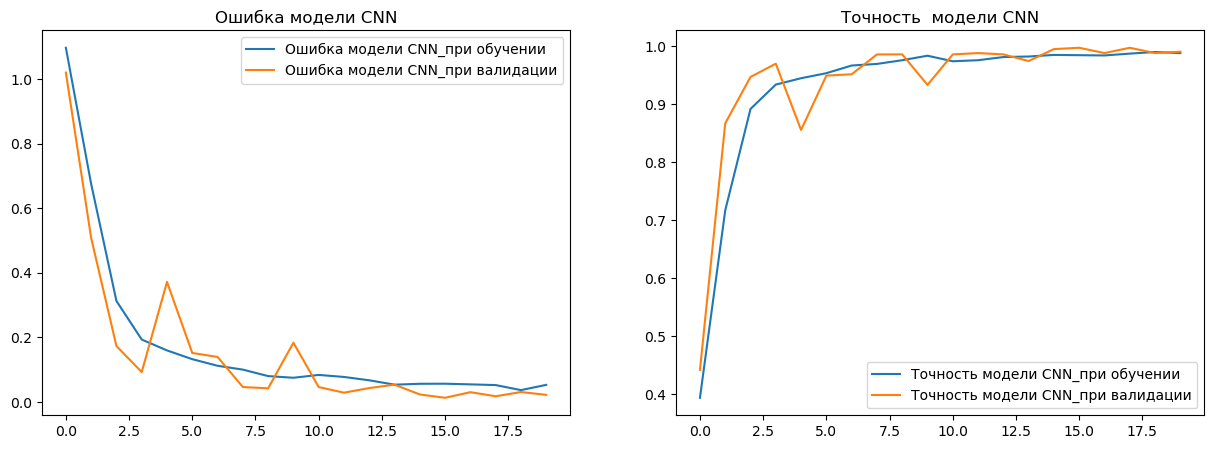

In [10]:
show_final_history(history)

# Модель на основе L1 регуляризации


Теперь, когда вы знаете, как мы будем кодировать модель и отображать архитектуру, давайте приступим к теории и коду регуляризованных моделей.

Регуляризация L1
Для регуляризации L1 вам необходимо добавить следующее значение к функции стоимости L (x,y) вашей модели.

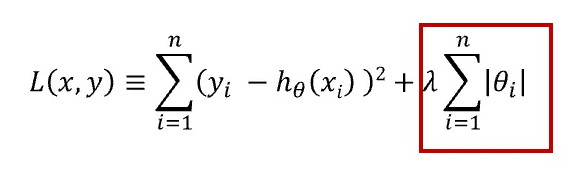

Здесь тета — это ваш параметр, который вы умножаете на свои входные данные, чтобы получить прогноз. При регуляризации L1 вы берете модули всех параметров и суммируете их. Лямбда устанавливается перед началом обучения.

Если вы увеличите значение лямбды, параметры будут небольшими, поскольку выражение L1, помеченное рамкой, будет наказывать ваши параметры.

Однако недостатком регуляризации L1 является то, что вы получите параметры с редкими значениями. Значения параметров будут близки к нулям.

Вы можете добавить регуляризатор L1 в слои, такие как conv_2d, указав kernel_regularizer.

Это фрагмент кода модели с регуляризатором L1.

In [11]:
model_l1 = tf.keras.models.Sequential([
    # layer 1
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(224, 224, 3), use_bias=True),
    tf.keras.layers.MaxPooling2D(2,2),
    # layer 2
    tf.keras.layers.Conv2D(64, (3,3), activation = 'relu', use_bias=True),
    tf.keras.layers.MaxPooling2D(2,2),
    # layer 3
    tf.keras.layers.Conv2D(128, (3,3), activation = 'relu', use_bias=True, kernel_regularizer =tf.keras.regularizers.l1( l=0.01) ),
    tf.keras.layers.MaxPooling2D(2,2),
    # layer 4
    tf.keras.layers.Conv2D(128, (3,3), activation = 'relu', use_bias=True,kernel_regularizer =tf.keras.regularizers.l1( l=0.01)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    # layer 5
    tf.keras.layers.Dense(512, activation = 'relu', use_bias=True, kernel_regularizer =tf.keras.regularizers.l1( l=0.01)),
    # layer 6
    tf.keras.layers.Dense(3, activation='softmax', use_bias=True)
    
])

Как вы можете видеть, мы добавили tf.keras.regularizer() внутри Conv2d, kernel_regularizer плотного слоя, и установили лямбду на 0.01. Для обучения и компиляции модели используйте тот же код, что и раньше.

In [12]:
model_l1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 222, 222, 64)      1792      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 111, 111, 64)     0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 109, 109, 64)      36928     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 26, 26, 128)     

In [13]:
model_l1.compile(loss = 'categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [14]:
history_l1 = model_l1.fit(train_gen, epochs=20, validation_data = val_gen, verbose = 1)


Epoch 1/20
69/69 [==============================] - 52s 749ms/step - loss: 97.8886 - accuracy: 0.3314 - val_loss: 50.8865 - val_accuracy: 0.3432
Epoch 2/20
69/69 [==============================] - 52s 745ms/step - loss: 40.7301 - accuracy: 0.3323 - val_loss: 31.0412 - val_accuracy: 0.3432
Epoch 3/20
69/69 [==============================] - 51s 743ms/step - loss: 32.2529 - accuracy: 0.3428 - val_loss: 33.4698 - val_accuracy: 0.3432
Epoch 4/20
69/69 [==============================] - 52s 747ms/step - loss: 32.2809 - accuracy: 0.3428 - val_loss: 31.0333 - val_accuracy: 0.3432
Epoch 5/20
69/69 [==============================] - 52s 748ms/step - loss: 32.2784 - accuracy: 0.3405 - val_loss: 33.5316 - val_accuracy: 0.3432
Epoch 6/20
69/69 [==============================] - 52s 746ms/step - loss: 32.3001 - accuracy: 0.3428 - val_loss: 31.0560 - val_accuracy: 0.3432
Epoch 7/20
69/69 [==============================] - 52s 746ms/step - loss: 32.2643 - accuracy: 0.3428 - val_loss: 33.5313 - val_ac

In [15]:
def show_final_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    ax[0].set_title('Ошибка модели при  регуляризации L1')
    ax[0].plot(history.epoch, history.history["loss"], label="Ошибка модели регуляризации L1_при обучении")
    ax[0].plot(history.epoch, history.history["val_loss"], label="Ошибка модели регуляризации L1_при валидации")
    ax[1].set_title('Точность  модели при регуляризации L1')
    ax[1].plot(history.epoch, history.history["accuracy"], label="Точность модели регуляризации L1_при обучении")
    ax[1].plot(history.epoch, history.history["val_accuracy"], label="Точность модели регуляризации L1_при валидации")
    ax[0].legend()
    ax[1].legend()

После обучения в течение 20 эпох (циклов) мы наблюдаем очень странный график точности.

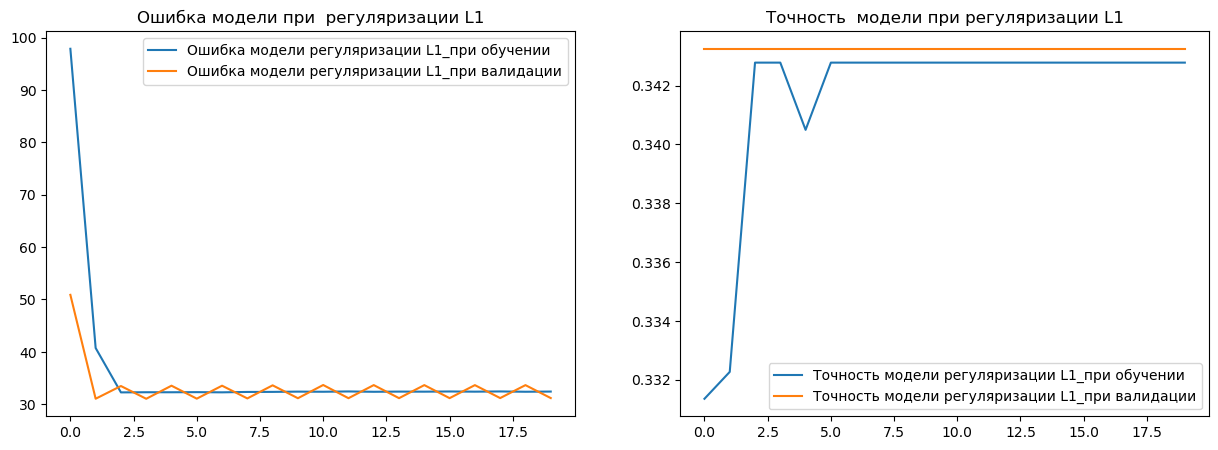

In [16]:
show_final_history(history_l1)

Вы можете видеть, что потери очень велики, а точность модели очень низкая. Есть несколько возможных причин таких значений.

У нас есть набор данных, содержащий всего 2188 изображений, что очень мало. Итак, нашей модели не хватило данных для обучения.
Регуляризация L1 делает параметры тета разреженными, что означает, что значения в основном равны нулям.

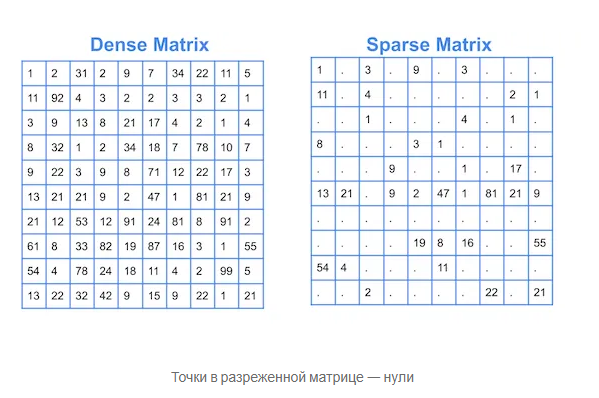

3. Мы добавили слишком много регуляризаторов, что может привести к тому, что модель не будет соответствовать данным.

Есть 3 способа улучшить производительность модели

Используйте больше данных
Используйте другой метод регуляризации
Используйте меньше регуляризатора

# Модель на основе L2 регуляризации

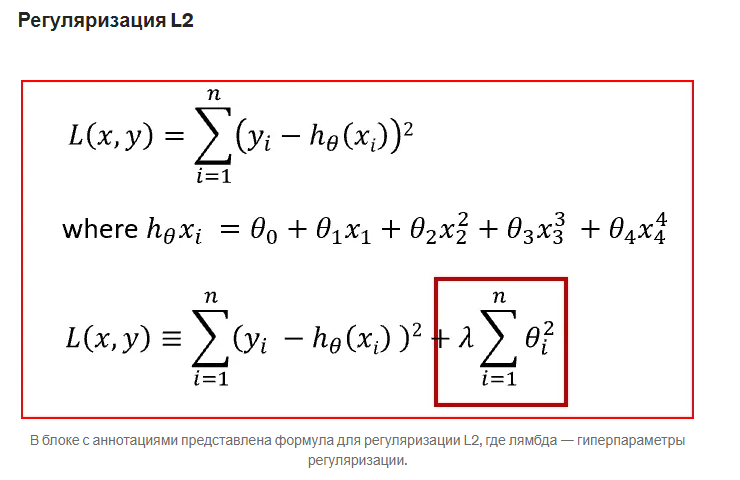

В регуляризации L2 мы берем сумму всех параметров в квадрате и добавляем ее к разнице квадратов фактического результата и прогнозов. Так же, как и в L1, если вы увеличите значение лямбды, значение параметров уменьшится, поскольку L2 наложит штрафы на параметры. Разница в том, что веса не будут редкими, и мы получим гораздо лучшие значения точности по сравнению с L1.

In [17]:
model_l2 = tf.keras.models.Sequential([
    # layer 1
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(224, 224, 3), use_bias=True),
    tf.keras.layers.MaxPooling2D(2,2),
    # layer 2
    tf.keras.layers.Conv2D(64, (3,3), activation = 'relu', use_bias=True),
    tf.keras.layers.MaxPooling2D(2,2),
    # layer 3
    tf.keras.layers.Conv2D(128, (3,3), activation = 'relu', use_bias=True, kernel_regularizer =tf.keras.regularizers.l2( l=0.01)),
    tf.keras.layers.MaxPooling2D(2,2),
    # layer 4
    tf.keras.layers.Conv2D(128, (3,3), activation = 'relu', use_bias=True , kernel_regularizer =tf.keras.regularizers.l2( l=0.01)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    # layer 5
    tf.keras.layers.Dense(512, activation = 'relu', use_bias=True,  kernel_regularizer =tf.keras.regularizers.l2( l=0.01)),
    
    # layer 6
    tf.keras.layers.Dense(3, activation='softmax', use_bias=True)
    
])

tf.keras.regularizers.l2() обозначает регуляризаторы L2. Через 20 эпох графики выглядят так. Тренируйтесь, используя тот же шаг, что и раньше.

In [18]:
model_l2.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 222, 222, 64)      1792      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 111, 111, 64)     0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 109, 109, 64)      36928     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 26, 26, 128)     

In [19]:
model_l2.compile(loss = 'categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [20]:
history_l2 = model_l2.fit(train_gen, epochs=20, validation_data = val_gen, verbose = 1)


Epoch 1/20
69/69 [==============================] - 52s 740ms/step - loss: 3.2607 - accuracy: 0.3793 - val_loss: 1.1764 - val_accuracy: 0.3593
Epoch 2/20
69/69 [==============================] - 51s 738ms/step - loss: 1.0404 - accuracy: 0.5434 - val_loss: 0.8452 - val_accuracy: 0.6842
Epoch 3/20
69/69 [==============================] - 51s 736ms/step - loss: 0.7560 - accuracy: 0.7358 - val_loss: 0.6224 - val_accuracy: 0.8467
Epoch 4/20
69/69 [==============================] - 51s 738ms/step - loss: 0.5485 - accuracy: 0.8464 - val_loss: 0.4050 - val_accuracy: 0.9039
Epoch 5/20
69/69 [==============================] - 51s 740ms/step - loss: 0.4588 - accuracy: 0.8693 - val_loss: 0.3431 - val_accuracy: 0.9268
Epoch 6/20
69/69 [==============================] - 51s 735ms/step - loss: 0.4030 - accuracy: 0.8926 - val_loss: 0.3805 - val_accuracy: 0.9108
Epoch 7/20
69/69 [==============================] - 51s 734ms/step - loss: 0.3721 - accuracy: 0.9059 - val_loss: 0.3696 - val_accuracy: 0.8924

In [21]:
def show_final_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    ax[0].set_title('Ошибка модели при  регуляризации L2')
    ax[0].plot(history.epoch, history.history["loss"], label="Ошибка модели регуляризации L2_при обучении")
    ax[0].plot(history.epoch, history.history["val_loss"], label="Ошибка модели регуляризации L2_при валидации")
    ax[1].set_title('Точность  модели при регуляризации L2')
    ax[1].plot(history.epoch, history.history["accuracy"], label="Точность модели регуляризации L2_при обучении")
    ax[1].plot(history.epoch, history.history["val_accuracy"], label="Точность модели регуляризации L2_при валидации")
    ax[0].legend()
    ax[1].legend()

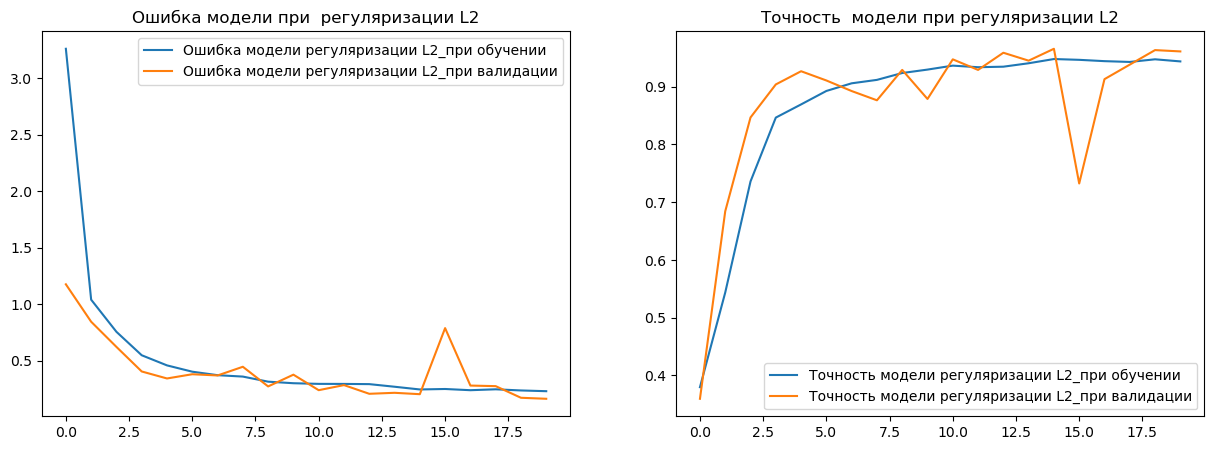

In [22]:
show_final_history(history_l2)


Поскольку параметры были не редкими, модель не подходила, и мы имеем низкие потери и высокую точность — именно то, что нам нужно.

Как именно наказывают L1 и L2?
Это связано с обратным распространением ошибки. Обратное распространение ошибки само по себе является отдельной темой, но основная идея проста.

На каждом этапе ваша модель делает прогнозы. Он находит разницу между фактическим результатом и прогнозом. Если разница не минимальна, модель должна сделать другой прогноз, который намного ближе к выходным данным. Чтобы делать разные прогнозы, модель должна иметь разные параметры, которые лучше предыдущих. Параметры обновляются путем определения градиента функции потерь на каждом шаге.

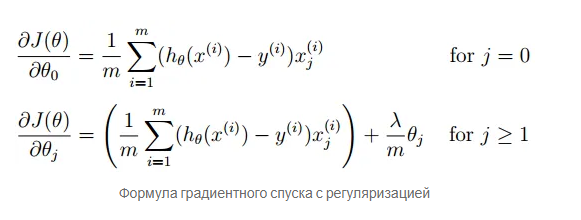

Таким образом регуляризаторы наказывают параметры модели.

# Регуляризация с  Dropout

Dropout — еще один метод регуляризации, широко используемый в моделях. Что он делает, так это удаляет некоторые случайные узлы в ваших слоях нейронной сети.

Таким образом, преимущество использования исключения заключается в том, что ни одному узлу в сети не будут назначены высокие значения параметров, в результате значения параметров будут рассредоточены, и выходные данные текущего слоя не будут зависеть от одного узла.

Архитектура модели такая:

In [23]:
model_drop = tf.keras.models.Sequential([
    # layer 1
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(224, 224, 3), use_bias=True),
    tf.keras.layers.MaxPooling2D(2,2),
    # layer 2
    tf.keras.layers.Conv2D(64, (3,3), activation = 'relu', use_bias=True),
    tf.keras.layers.MaxPooling2D(2,2),
    # layer 3
    tf.keras.layers.Conv2D(128, (3,3), activation = 'relu', use_bias=True),
    tf.keras.layers.Dropout( 0.2),
    tf.keras.layers.MaxPooling2D(2,2),
    # layer 4
    tf.keras.layers.Conv2D(128, (3,3), activation = 'relu', use_bias=True),    
    tf.keras.layers.Dropout( 0.2), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    # layer 5
    tf.keras.layers.Dense(512, activation = 'relu', use_bias=True),
    tf.keras.layers.Dropout( 0.2),
    # layer 6
    tf.keras.layers.Dense(3, activation='softmax', use_bias=True)
    
])

tf.keras.layers.Dropout(0.2) удаляет входные слои с вероятностью 0,2.

In [24]:
model_drop.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 222, 222, 64)      1792      
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 111, 111, 64)     0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 109, 109, 64)      36928     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 54, 54, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 52, 52, 128)       73856     
                                                                 
 dropout (Dropout)           (None, 52, 52, 128)      

In [25]:
model_drop.compile(loss = 'categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [26]:
history_drop = model_drop.fit(train_gen, epochs=20, validation_data = val_gen, verbose = 1)


Epoch 1/20
69/69 [==============================] - 53s 766ms/step - loss: 1.0805 - accuracy: 0.4493 - val_loss: 0.8314 - val_accuracy: 0.6270
Epoch 2/20
69/69 [==============================] - 53s 769ms/step - loss: 0.4655 - accuracy: 0.8222 - val_loss: 0.4932 - val_accuracy: 0.7712
Epoch 3/20
69/69 [==============================] - 53s 764ms/step - loss: 0.3245 - accuracy: 0.8972 - val_loss: 0.2369 - val_accuracy: 0.9519
Epoch 4/20
69/69 [==============================] - 53s 765ms/step - loss: 0.1716 - accuracy: 0.9442 - val_loss: 0.1334 - val_accuracy: 0.9497
Epoch 5/20
69/69 [==============================] - 53s 763ms/step - loss: 0.1604 - accuracy: 0.9506 - val_loss: 0.1468 - val_accuracy: 0.9657
Epoch 6/20
69/69 [==============================] - 53s 761ms/step - loss: 0.1431 - accuracy: 0.9557 - val_loss: 0.1282 - val_accuracy: 0.9474
Epoch 7/20
69/69 [==============================] - 53s 765ms/step - loss: 0.1095 - accuracy: 0.9625 - val_loss: 0.0831 - val_accuracy: 0.9794

После обучения и визуализации с помощью приведенного выше кода график выглядит следующим образом:

In [27]:
def show_final_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    ax[0].set_title('Ошибка модели при  регуляризации с Dropout ')
    ax[0].plot(history.epoch, history.history["loss"], label="Ошибка модели регуляризации с Dropout_при обучении")
    ax[0].plot(history.epoch, history.history["val_loss"], label="Ошибка модели регуляризации с Dropout_при валидации")
    ax[1].set_title('Точность  модели при регуляризации с Dropout')
    ax[1].plot(history.epoch, history.history["accuracy"], label="Точность модели регуляризации с Dropout_при обучении")
    ax[1].plot(history.epoch, history.history["val_accuracy"], label="Точность модели регуляризации с Dropout_при валидации")
    ax[0].legend()
    ax[1].legend()

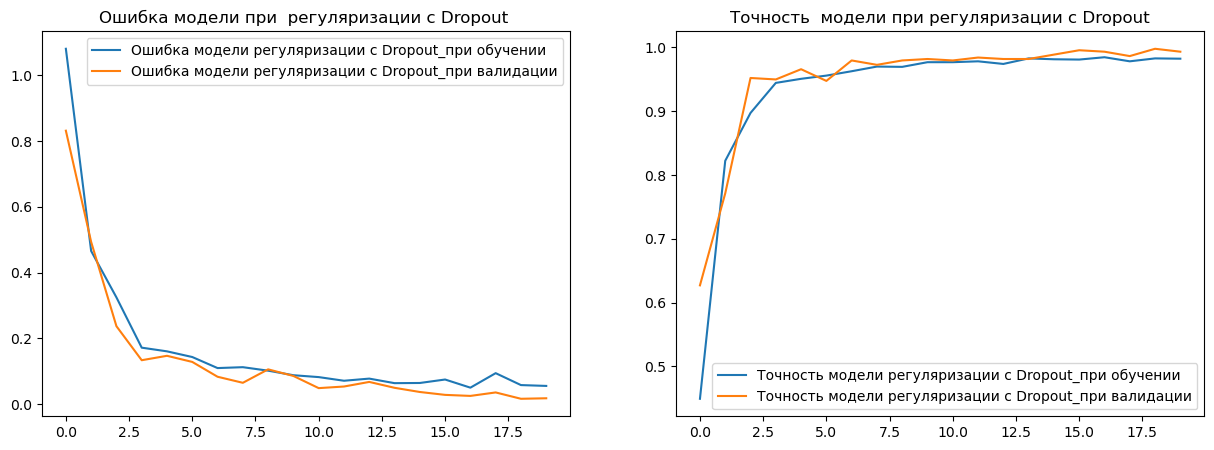

In [28]:
show_final_history(history_drop)


Потери очень малы, а точность модели исключения высока. Параметры не редкие. Поэтому, если вы планируете использовать регуляризацию в своих моделях, выбирайте модели отсева.

Обычно отсев размещается на полностью связанных слоях или плотных слоях только потому, что они имеют большее количество параметров и, следовательно, они, вероятно, будут чрезмерно коадаптироваться, вызывая переобучение.

Улучшение производительности модели
Есть несколько способов улучшить производительность моделей.

Используйте меньше конв-слоев. Я использовал 4 слоя конвекций, вы можете выбрать два.
Используйте регуляризацию только на слое с самыми высокими параметрами.
Соберите больше данных.
Поздравляю с тем, что вы зашли так далеко. Надеюсь, прочитав эту статью, вы сможете лучше понять регуляризацию.